### Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets, transforms
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
torch.__version__

'2.6.0+cu124'

In [3]:
torchvision.__version__

'0.21.0+cu124'

In [4]:
torch.cuda.is_available()

True

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
print(f"using device:{device}")

using device:cuda


In [7]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
random.seed(42)

### Initializing the Hyperparameters

In [102]:
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 3e-4
PATCH_SIZE = 4
NUM_CLASSES = 20
IMAGE_SIZE = 32
NUM_CHANNELS = 3
EMBED_DIM = 256
NUM_HEADS = 16
DEPTH = 10
MLP_DIMENSION = 512
DROP_RATE = 0.1

### Data Transformation

In [103]:
transform = transforms.Compose([
    transforms.RandomCrop(32,padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)

])

### Loading the Dataset

In [104]:
train_dataset = datasets.CIFAR10(root = 'data', train = True, download = True, transform = transform)


In [105]:
test_dataset = datasets.CIFAR10(root = 'data',train= False,download = True, transform = transform)

In [106]:
train_dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [107]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [108]:
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = False)

In [110]:
print(f"dataloader:{train_loader, test_loader}")
print(f"length of train_loader:{len(train_loader)} batches of {BATCH_SIZE}")
print(f"length of test_loader:{len(test_loader)} batches of {BATCH_SIZE}")

dataloader:(<torch.utils.data.dataloader.DataLoader object at 0x79eb115261d0>, <torch.utils.data.dataloader.DataLoader object at 0x79eaf58f1b50>)
length of train_loader:391 batches of 128
length of test_loader:79 batches of 128


### Patch Embedding Layer

In [112]:
class PatchEmbedding(nn.Module):
  def __init__(self,image_size, patch_size, in_channels,embed_dim):
    super().__init__()
    self.patch_size = patch_size
    self.proj = nn.Conv2d(in_channels = in_channels, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size)
    num_patches = (image_size// patch_size) ** 2
    self.cls_token = nn.Parameter(torch.randn(1,1,embed_dim))
    self.pos_embed = nn.Parameter(torch.randn(1,1+num_patches,embed_dim))
  def forward(self,x:torch.Tensor):
    B = x.size(0)
    x = self.proj(x)
    x = x.flatten(2).transpose(1,2)
    cls_token = self.cls_token.expand(B,-1,-1)
    x = torch.cat((cls_token,x),dim = 1)
    x = x + self.pos_embed
    return x

### Multi Layer Perceptron

In [113]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, drop_out):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.fc2 = nn.Linear(hidden_features,in_features)
    self.dropout = nn.Dropout(drop_out)
  def forward(self,x):
    x = self.dropout(F.gelu(self.fc1(x)))
    x = self.dropout(self.fc2(x))
    return x


### Encoder Layer

In [114]:
class TransformerEncoderLayer(nn.Module):
  def __init__(self, embed_dim, num_heads, mlp_dim, drop_out):
    super().__init__()
    self.norm1 = nn.LayerNorm(embed_dim)
    self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout = drop_out,batch_first = True)
    self.norm2 = nn.LayerNorm(embed_dim)
    self.mlp = MLP(embed_dim,mlp_dim,drop_out)
  def forward(self,x):
    x = x + self.attn(self.norm1(x),self.norm1(x),self.norm1(x))[0]
    x = x + self.mlp(self.norm2(x))
    return x

### Vision Transformer Model

In [115]:
class VisionTransformer(nn.Module):
  def __init__(self, image_size, patch_size, in_channels, num_classes,embed_dim, num_heads, depth, mlp_dim, drop_out):
    super().__init__()
    self.patch_embed = PatchEmbedding(image_size, patch_size, in_channels, embed_dim)
    self.encoder = nn.Sequential(
        *[TransformerEncoderLayer(embed_dim, num_heads, mlp_dim, drop_out)
        for _ in range(depth)]
    )
    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, num_classes)
  def forward(self,x):
    x = self.patch_embed(x)
    x = self.encoder(x)
    x = self.norm(x)
    cls_token = x[:,0]
    return self.head(cls_token)

In [116]:
model = VisionTransformer(
    IMAGE_SIZE,
    PATCH_SIZE,
    NUM_CHANNELS,
    NUM_CLASSES,
    EMBED_DIM,
    NUM_HEADS,
    DEPTH,
    MLP_DIMENSION,
    DROP_RATE
).to(device)

In [118]:
model

VisionTransformer(
  (patch_embed): PatchEmbedding(
    (proj): Conv2d(3, 256, kernel_size=(4, 4), stride=(4, 4))
  )
  (encoder): Sequential(
    (0): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=256, out_features=512, bias=True)
        (fc2): Linear(in_features=512, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (1): TransformerEncoderLayer(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP

### Loss Function and Optimizer

In [119]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = LEARNING_RATE)


In [120]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0003
    maximize: False
    weight_decay: 0
)

### Train Function

In [121]:
def train(model, loader, optimizer, criterion):
  model.train()
  total_loss , correct = 0,0
  for x, y in loader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    correct += (out.argmax(1)==y).type(torch.float).sum().item()
  return total_loss/len(loader.dataset), correct/len(loader.dataset)

In [122]:
def evaluate(model,loader):
  model.eval()
  correct = 0
  with torch.inference_mode():
    for x, y in loader:
      x, y = x.to(device), y.to(device)
      out = model(x)
      correct += (out.argmax(1) == y).sum().item()
  return correct/ len(loader.dataset)

In [123]:
from tqdm.auto import tqdm

In [124]:
train_accuracies = []
test_accuracies = []
for epoch in tqdm(range(EPOCHS)):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  test_acc = evaluate(model, test_loader)
  train_accuracies.append(train_acc)
  test_accuracies.append(test_acc)
  print(f"epoch:{epoch+1}/{EPOCHS}, train_loss:{train_loss:.4f}, train_acc:{train_acc:.4f}%, test_acc:{test_acc:.4f}% ")

  0%|          | 0/30 [00:00<?, ?it/s]

epoch:1/30, train_loss:0.0155, train_acc:0.2687%, test_acc:0.3493% 
epoch:2/30, train_loss:0.0132, train_acc:0.3873%, test_acc:0.4265% 
epoch:3/30, train_loss:0.0123, train_acc:0.4338%, test_acc:0.4589% 
epoch:4/30, train_loss:0.0116, train_acc:0.4664%, test_acc:0.4932% 
epoch:5/30, train_loss:0.0111, train_acc:0.4913%, test_acc:0.4974% 
epoch:6/30, train_loss:0.0107, train_acc:0.5117%, test_acc:0.5233% 
epoch:7/30, train_loss:0.0103, train_acc:0.5305%, test_acc:0.5412% 
epoch:8/30, train_loss:0.0099, train_acc:0.5470%, test_acc:0.5647% 
epoch:9/30, train_loss:0.0096, train_acc:0.5643%, test_acc:0.5708% 
epoch:10/30, train_loss:0.0092, train_acc:0.5823%, test_acc:0.5857% 
epoch:11/30, train_loss:0.0089, train_acc:0.5950%, test_acc:0.5939% 
epoch:12/30, train_loss:0.0087, train_acc:0.6074%, test_acc:0.6177% 
epoch:13/30, train_loss:0.0084, train_acc:0.6192%, test_acc:0.6214% 
epoch:14/30, train_loss:0.0082, train_acc:0.6283%, test_acc:0.6225% 
epoch:15/30, train_loss:0.0079, train_acc:0

In [125]:
train_accuracies

[0.26868,
 0.38732,
 0.43384,
 0.4664,
 0.49134,
 0.51168,
 0.53046,
 0.547,
 0.5643,
 0.58228,
 0.59504,
 0.6074,
 0.6192,
 0.62834,
 0.64094,
 0.65082,
 0.66022,
 0.66698,
 0.67712,
 0.6841,
 0.69236,
 0.70234,
 0.70986,
 0.71918,
 0.72574,
 0.73228,
 0.7385,
 0.7433,
 0.74762,
 0.75302]

In [126]:
test_accuracies

[0.3493,
 0.4265,
 0.4589,
 0.4932,
 0.4974,
 0.5233,
 0.5412,
 0.5647,
 0.5708,
 0.5857,
 0.5939,
 0.6177,
 0.6214,
 0.6225,
 0.6343,
 0.6428,
 0.6592,
 0.6685,
 0.6584,
 0.6781,
 0.6801,
 0.691,
 0.6973,
 0.704,
 0.6975,
 0.7057,
 0.7065,
 0.7026,
 0.7154,
 0.7216]

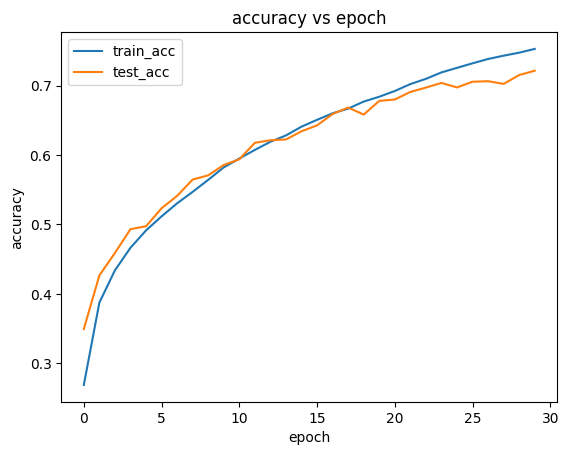

In [127]:
plt.plot(train_accuracies, label = 'train_acc')
plt.plot(test_accuracies, label = 'test_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs epoch')
plt.show()

In [128]:
test_dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

In [129]:
test_dataset[0][0] /2 + 0.5

tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.5961, 0.6353, 0.6196],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.1804, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1255, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.1059, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.2706, 0.2510, 0.2039],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.6314, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.5529, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.5216, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.4078, 0.4039, 0.

In [130]:
def predict_and_plot(model,dataset, classes, grid_size=3):
  model.eval()
  fig, axes = plt.subplots(grid_size,grid_size, figsize = (9,9))
  for i in range(grid_size):
    for j in range(grid_size):
      index = random.randint(0,len(dataset)-1)
      image, true_label = dataset[index]
      input_tensor = image.unsqueeze(dim = 0).to(device)
      with torch.inference_mode():
        output = model(input_tensor)
        _,predicted = torch.max(output.data,1)
      image = image /2 + 0.5
      npimg = image.cpu().numpy()
      axes[i,j].imshow(np.transpose(npimg,(1,2,0)))
      truth = classes[true_label] == classes[predicted.item()]
      if truth:
        color = 'g'
      else:
        color = 'r'
      axes[i,j].set_title(f"truth: {classes[true_label]}\n, predicted :{classes[predicted.item()]}",fontsize = 10, color = color)
      axes[i,j].axis('off')
  plt.tight_layout()
  plt.show()

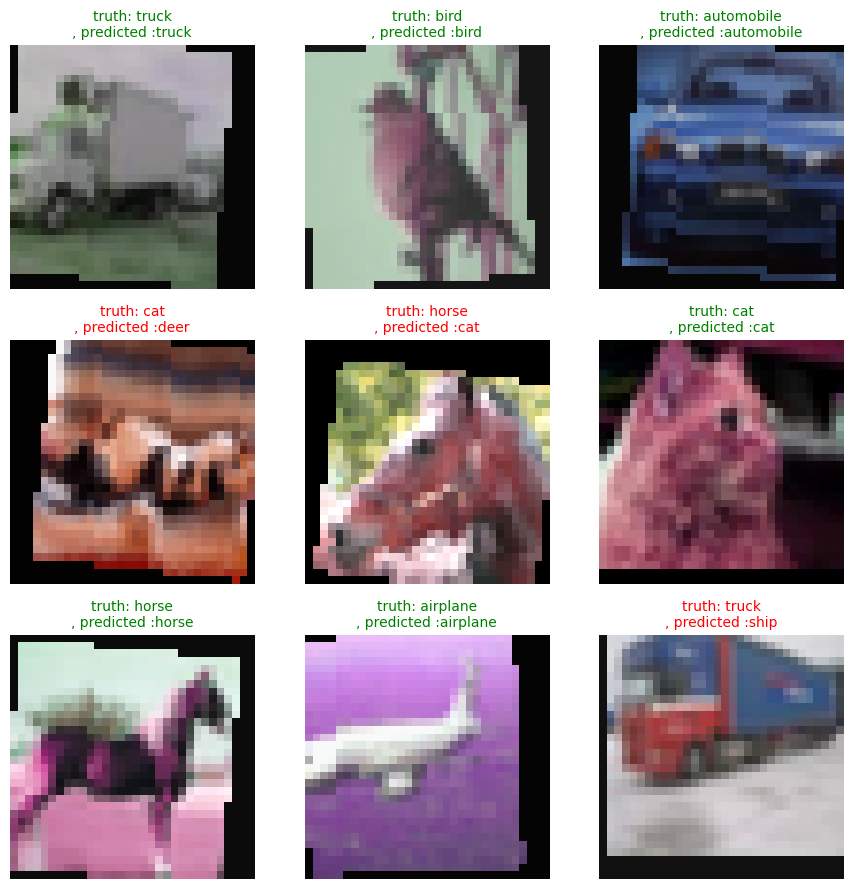

In [131]:
predict_and_plot(model, test_dataset, test_dataset.classes)